## Pitch Names Classifier

In [1]:
import numpy as np

from htm.bindings.sdr import SDR
from htm.bindings.encoders import ScalarEncoder, ScalarEncoderParameters
from htm.algorithms import SpatialPooler as SP
from htm.algorithms import TemporalMemory as TM
from htm.bindings.algorithms import Classifier
from htm.bindings.algorithms import Predictor

import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [2]:
pitchNames = ("A","B","C","D","X","Y")
print(len(pitchNames))

scalarEncoderParams = ScalarEncoderParameters()
scalarEncoderParams.minimum = 0
scalarEncoderParams.maximum = len(pitchNames)-1
scalarEncoderParams.activeBits = 3
scalarEncoderParams.category = True

enc = ScalarEncoder(scalarEncoderParams)

print ("A: ", enc.encode(0))
print ("B: ", enc.encode(1))
print ("C: ", enc.encode(2))
print ("D: ", enc.encode(3))
print ("X: ", enc.encode(4))
print ("Y: ", enc.encode(5))
#print ("?: ", enc.encode(6))

6
A:  SDR( 18 ) 0, 1, 2
B:  SDR( 18 ) 3, 4, 5
C:  SDR( 18 ) 6, 7, 8
D:  SDR( 18 ) 9, 10, 11
X:  SDR( 18 ) 12, 13, 14
Y:  SDR( 18 ) 15, 16, 17


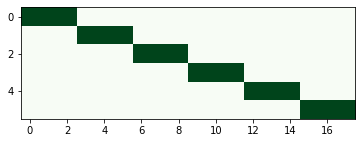

In [3]:
n_samples = int(enc.parameters.maximum - enc.parameters.minimum + 1)

sdrs = []
for i in np.linspace(enc.parameters.minimum, enc.parameters.maximum, n_samples):
    sdrs.append( enc.encode( i ).dense )

    clear_output(wait = True)
    plt.cla
    plt.imshow(np.array(sdrs), cmap = "Greens")
    plt.show()

In [4]:
inputSDR  = SDR( dimensions = (18, ) )
activeSDR = SDR( dimensions = (576,) )
sp = SP(inputDimensions  = inputSDR.dimensions,
        columnDimensions = activeSDR.dimensions,
        localAreaDensity = 0.02,
        globalInhibition = True,
        seed             = 1,
        synPermActiveInc   = 0.01,
        synPermInactiveDec = 0.008)

print(sp)

Spatial Pooler Connections:
    Inputs (18) ~> Outputs (576) via Segments (576)
    Segments on Cell Min/Mean/Max 1 / 1 / 1
    Potential Synapses on Segment Min/Mean/Max 9 / 9 / 9
    Connected Synapses on Segment Min/Mean/Max 0 / 4.43576 / 9
    Synapses Dead (0%) Saturated (0%)
    Synapses pruned (0%) Segments pruned (0%)



In [5]:
clsr = Classifier()

In [6]:
tm = TM(
    columnDimensions = (576,),
    cellsPerColumn=8,
    initialPermanence=0.5,
    connectedPermanence=0.5,
    minThreshold=8,
    maxNewSynapseCount=20,
    permanenceIncrement=0.1,
    permanenceDecrement=0.0,
    activationThreshold=8,
)
print(tm)

Temporal Memory Connections:
    Inputs (0) ~> Outputs (4608) via Segments (0)
    Segments on Cell Min/Mean/Max 0 / 0 / 0
    Potential Synapses on Segment Min/Mean/Max 4294967295 / nan / 0
    Connected Synapses on Segment Min/Mean/Max 65535 / nan / 0
    Synapses Dead (nan%) Saturated (nan%)
    Synapses pruned (nan%) Segments pruned (nan%)



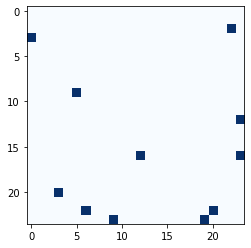

In [7]:
for i in range(len(pitchNames)):
    inputSDR = enc.encode(i)
    print("input SDR: ",inputSDR)
    sp.compute(inputSDR, True, activeSDR)
    print("Active SDR: ",activeSDR)
    clsr.learn( activeSDR.addNoise(0.2), i )
    print("Classifier learn: ",i)
    print("")

    clear_output(wait = True)
    plt.cla
    sampleSDR=activeSDR.dense.reshape(24,24)
    plt.imshow(sampleSDR, cmap = "Blues")
    plt.pause(0.01)

In [8]:
#phrase1="ABCD"
#phrase1=[0,1,2,3]
#phrase2="XBCY"
#phrase2=[4,1,2,5]

phrase=[0,1,2,3,4,1,2,5]

In [9]:
seq=[]
for i in range(10):
    seq.extend(phrase)
print(seq)

predictor = Predictor( steps=[1,2,3,4], alpha=0.1)
predictor_resolution = 1

[0, 1, 2, 3, 4, 1, 2, 5, 0, 1, 2, 3, 4, 1, 2, 5, 0, 1, 2, 3, 4, 1, 2, 5, 0, 1, 2, 3, 4, 1, 2, 5, 0, 1, 2, 3, 4, 1, 2, 5, 0, 1, 2, 3, 4, 1, 2, 5, 0, 1, 2, 3, 4, 1, 2, 5, 0, 1, 2, 3, 4, 1, 2, 5, 0, 1, 2, 3, 4, 1, 2, 5, 0, 1, 2, 3, 4, 1, 2, 5]


In [10]:
predictions = {1: [], 2: [], 3: [], 4: []}
for i in range(len(seq)):
    inputSDR = enc.encode(seq[i])
    sp.compute(inputSDR, True, activeSDR)

    tm.compute( activeSDR, learn=True)
    
    predictor.learn(i, tm.getActiveCells(), int(seq[i] / predictor_resolution))

    pdf = predictor.infer( tm.getActiveCells() )
    for n in (1,2,3,4):
        if pdf[n]:
            predictions[n].append( np.argmax( pdf[n] ) * predictor_resolution )
        else:
            predictions[n].append(float('nan'))
print(predictions)

{1: [nan, 0, 0, 0, 4, 2, 3, 3, 1, 2, 5, 4, 1, 2, 3, 0, 1, 2, 5, 4, 1, 2, 3, 0, 1, 2, 5, 4, 1, 2, 3, 0, 1, 2, 5, 4, 1, 2, 3, 0, 1, 2, 5, 4, 1, 2, 3, 0, 1, 2, 5, 4, 1, 2, 3, 0, 1, 2, 5, 4, 1, 2, 3, 0, 1, 2, 5, 4, 1, 2, 3, 0, 1, 2, 5, 4, 1, 2, 3, 0], 2: [nan, nan, 0, 0, 4, 3, 4, 4, 2, 5, 0, 1, 2, 5, 4, 1, 2, 3, 0, 1, 2, 5, 4, 1, 2, 3, 0, 1, 2, 5, 4, 1, 2, 3, 0, 1, 2, 5, 4, 1, 2, 3, 0, 1, 2, 5, 4, 1, 2, 3, 0, 1, 2, 5, 4, 1, 2, 3, 0, 1, 2, 5, 4, 1, 2, 3, 0, 1, 2, 5, 4, 1, 2, 3, 0, 1, 2, 5, 4, 1], 3: [nan, nan, nan, 0, 0, 4, 1, 1, 3, 0, 1, 2, 5, 0, 1, 2, 3, 4, 1, 2, 5, 0, 1, 2, 3, 4, 1, 2, 5, 0, 1, 2, 3, 4, 1, 2, 5, 0, 1, 2, 3, 4, 1, 2, 5, 0, 1, 2, 3, 4, 1, 2, 5, 0, 1, 2, 3, 4, 1, 2, 5, 0, 1, 2, 3, 4, 1, 2, 5, 0, 1, 2, 3, 4, 1, 2, 5, 0, 1, 2], 4: [nan, nan, nan, nan, 0, 1, 2, 2, 4, 1, 2, 5, 0, 1, 2, 3, 4, 1, 2, 5, 0, 1, 2, 3, 4, 1, 2, 5, 0, 1, 2, 3, 4, 1, 2, 5, 0, 1, 2, 3, 4, 1, 2, 5, 0, 1, 2, 3, 4, 1, 2, 5, 0, 1, 2, 3, 4, 1, 2, 5, 0, 1, 2, 3, 4, 1, 2, 5, 0, 1, 2, 3, 4, 1, 2, 5, 0, 1, 2, 3]}

In [11]:
test=[0,1,2,3]
#test=[4,1,2,5]

test_predictions = {1: [], 2: [], 3: [], 4: []}
for j in range(len(test)):
    inputSDR = enc.encode(test[j])
    sp.compute(inputSDR, True, activeSDR)

    tm.compute( activeSDR, learn=False)
    
    predictor.learn(j+len(seq), tm.getActiveCells(), int(test[j] / predictor_resolution))

    pdf = predictor.infer( tm.getActiveCells() )
    for n in (1,2,3,4):
        if pdf[n]:
            test_predictions[n].append( np.argmax( pdf[n] ) * predictor_resolution )
        else:
            test_predictions[n].append(float('nan'))
print(test_predictions)

{1: [1, 2, 5, 4], 2: [2, 3, 0, 1], 3: [3, 4, 1, 2], 4: [4, 1, 2, 5]}


In [12]:
#test=[0,1,2,3]
test=[4,1,2,5]

test_predictions = {1: [], 2: [], 3: [], 4: []}
for j in range(len(test)):
    inputSDR = enc.encode(test[j])
    sp.compute(inputSDR, True, activeSDR)

    tm.compute( activeSDR, learn=False)
    
    predictor.learn(j+len(seq)+len(test), tm.getActiveCells(), int(test[j] / predictor_resolution))

    pdf = predictor.infer( tm.getActiveCells() )
    for n in (1,2,3,4):
        if pdf[n]:
            test_predictions[n].append( np.argmax( pdf[n] ) * predictor_resolution )
        else:
            test_predictions[n].append(float('nan'))
print(test_predictions)

{1: [1, 2, 3, 0], 2: [2, 5, 4, 1], 3: [5, 0, 1, 2], 4: [0, 1, 2, 3]}


In [ ]:
["C","C","G","G","A","A","G","F","F","E","E","D","D","C"]

In [ ]:
["C","G","G","G","A","A","G","F","F","E","E","D","D","C"]